**I will implement a simple 3-layer neural network from scratch**

1-Packages

In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.linear_model

2-Generating a dataset

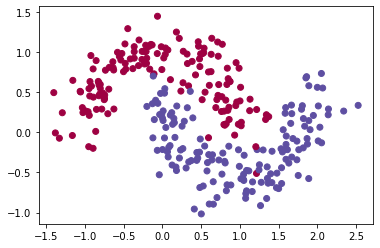

In [25]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(300, noise=0.20)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)
plt.show()

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements.

Our goal is to train a Machine Learning classifier that predicts the correct class (male of female) given the x- and y- coordinates

# Logistic Regression

In [26]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
for i in range(1000):
     clf.fit(X, y)

In [27]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

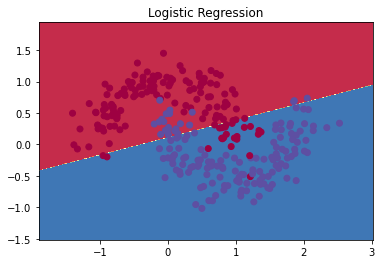

In [28]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it’s unable to capture the “moon shape” of our data.

# Training a Neural Network

Let’s now build a 3-layer neural network with one input layer, one hidden layer, and  output layer.

# -Hyperparameter 

**size of the hidden layer**

While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science We will play with the number of nodes in the hidden later later on and see how it affects our output.

**activation function for our hidden layer**

1-use tanh, which performs quite well in many scenarios

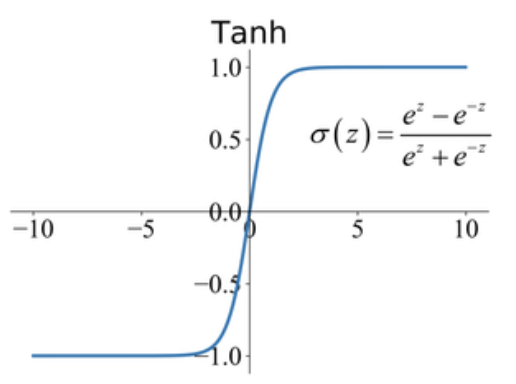

**the activation function for the output layer will be the softmax**

which is a way to convert raw scores to probabilities. If you’re familiar with the logistic function you can think of softmax as its generalization to multiple classes.

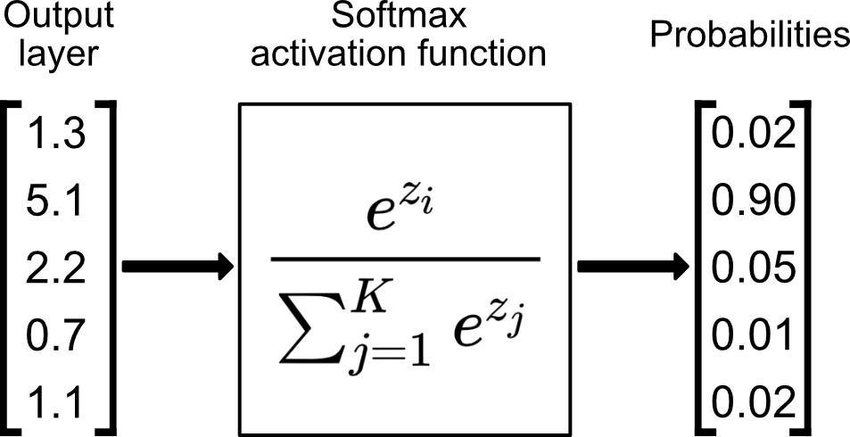

# How our network is working ?...

**there are two concepts :**
-forward pass
-backward pass

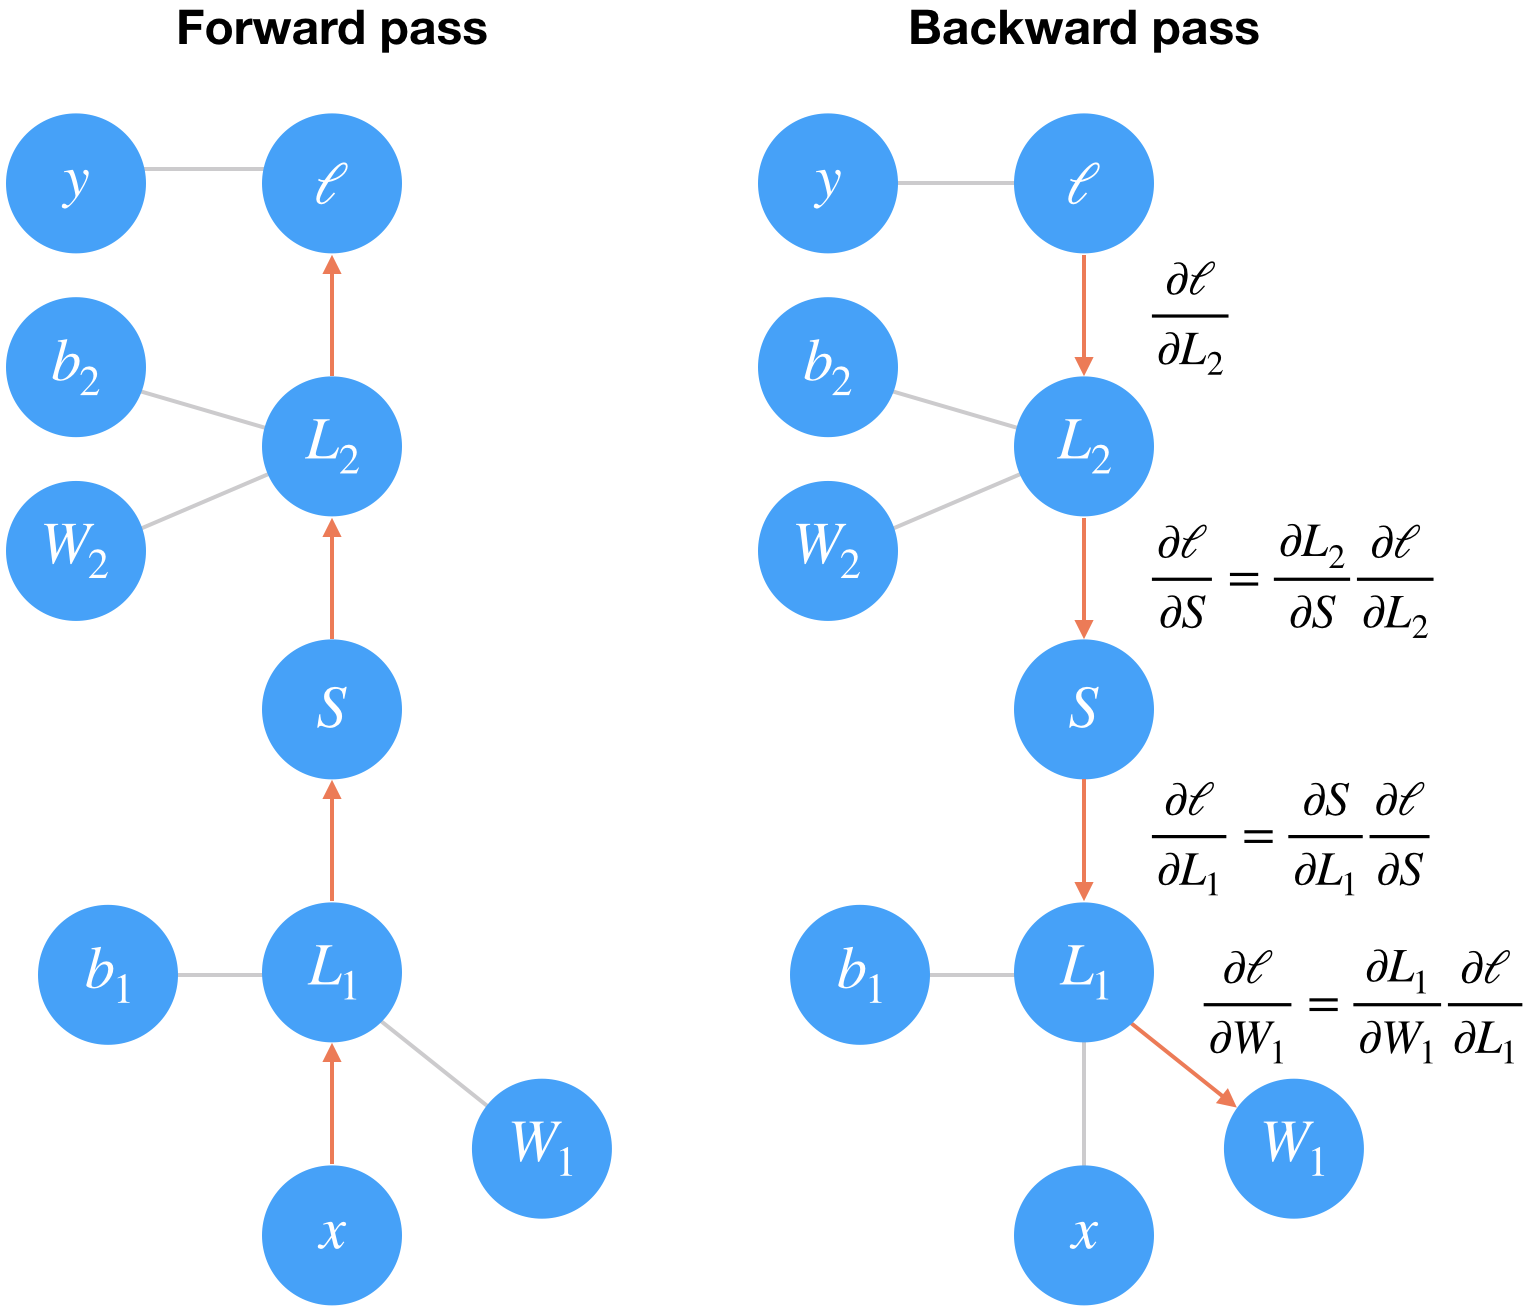

**Learning the Parameters**

We can use gradient descent to find this minimum. We will implement the most vanilla version of gradient descent

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters:


To calculate these gradients we use the famous backpropagation algorithm, which is a way to efficiently calculate the gradients starting from the output. I won’t go into detail how backpropagation works

# Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent

In [34]:
num_examples= len(X)  #number of traning set
nn_input_dim= 2   #input layer dimensionality
nn_output_dim= 2  #output layer dimensionality

# Gradient descent parameters
epsilon = 0.01  #learning rate for gradient descent
reg_lambda = 0.01  #regularization strength


**First let’s implement the loss function we defined above. We use this to evaluate how well our model is doing:**

In [32]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return 1./num_examples * data_loss

**Cross-Entropy
Hand in hand with the softmax function is the cross-entropy function. Here's the formula for it:**

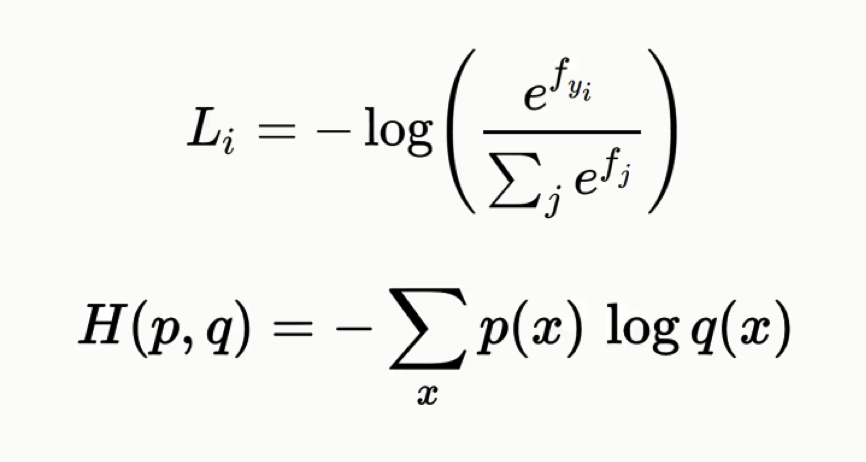

**We also implement a helper function to calculate the output of the network It does forward propagation as defined above and returns the class with the highest probability.**

In [64]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return np.argmax(probs, axis=1)

**Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.**

In [66]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print ("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

## A network with a hidden layer of size 3:

In [67]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)


Loss after iteration 0: 0.381135
Loss after iteration 1000: 0.065193
Loss after iteration 2000: 0.061929
Loss after iteration 3000: 0.061893
Loss after iteration 4000: 0.062402
Loss after iteration 5000: 0.062002
Loss after iteration 6000: 0.062196
Loss after iteration 7000: 0.062972
Loss after iteration 8000: 0.062656
Loss after iteration 9000: 0.062858
Loss after iteration 10000: 0.063315
Loss after iteration 11000: 0.063417
Loss after iteration 12000: 0.065922
Loss after iteration 13000: 0.063806
Loss after iteration 14000: 0.063311
Loss after iteration 15000: 0.062923
Loss after iteration 16000: 0.062911
Loss after iteration 17000: 0.062326
Loss after iteration 18000: 0.062896
Loss after iteration 19000: 0.063127


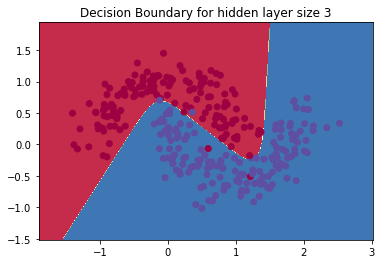

In [71]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

## Varying the hidden layer size

In the example above we picked a hidden layer size of 3 Let’s now get a sense of how varying the hidden layer size affects the result.

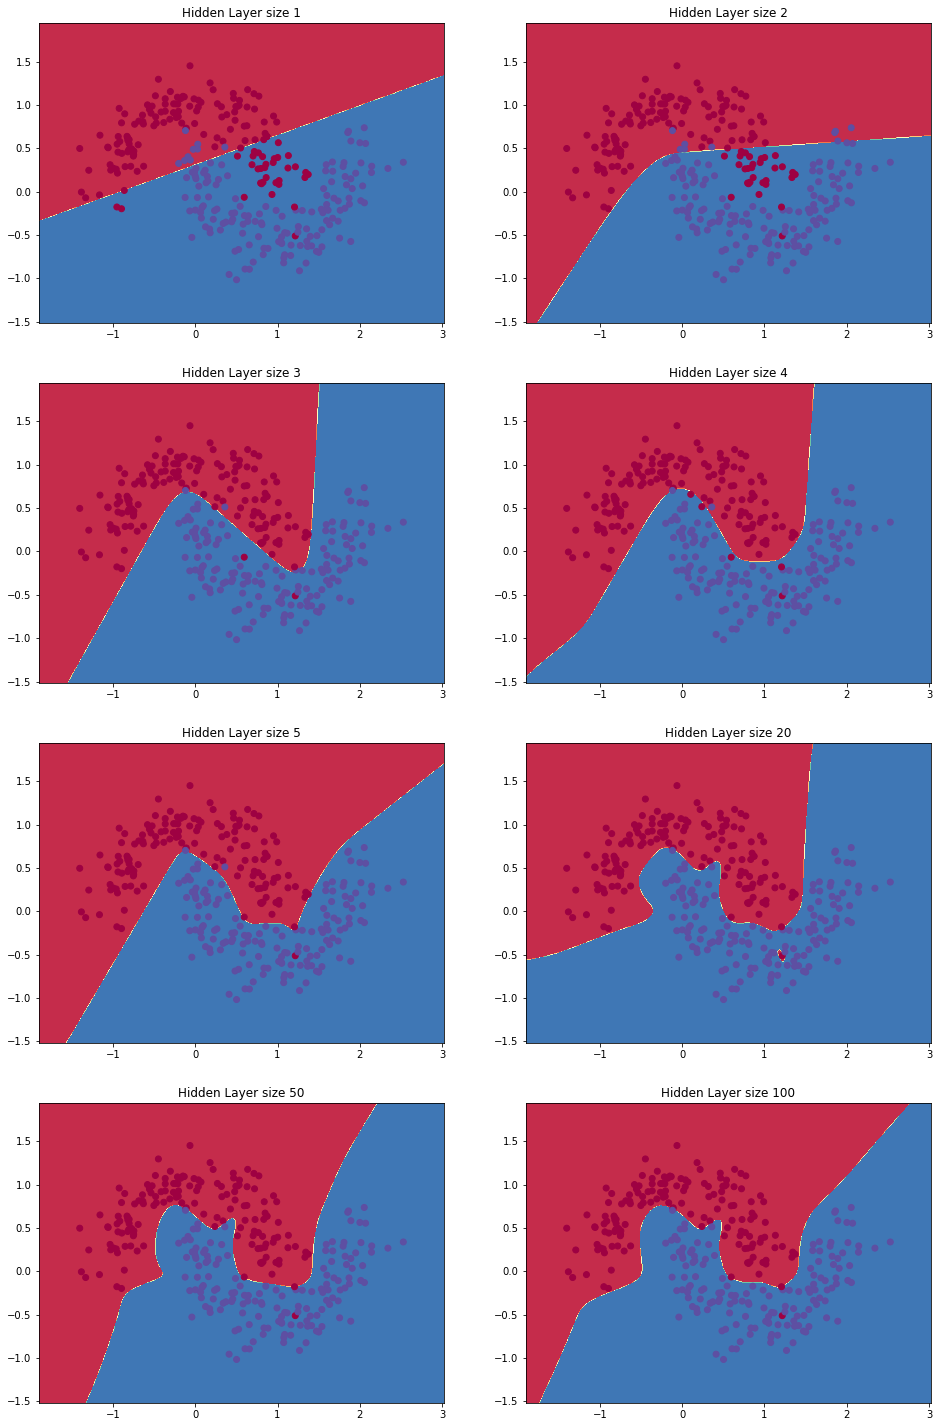

In [72]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50,100]

for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
    
plt.show()

**Yay! This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.**

## Reference:

[Denny’s Blog](https://dennybritz.com/posts/wildml/implementing-a-neural-network-from-scratch/#how-our-network-makes-predictions)

[CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-case-study/)